In [ ]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.7 MB/s eta 0:00:00


In [ ]:
!pip install pykrige

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.7/909.7 kB 14.3 MB/s eta 0:00:00


In [ ]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import netCDF4 as nc
from netCDF4 import Dataset
from datetime import datetime
import pykrige
from pykrige.ok import OrdinaryKriging

# Data Preprocessing

In [ ]:
# Latitude and longitude bounds
lat_min, lat_max = 26, 29
lon_min, lon_max = 80, 83

##Extracting ESACCI Data as a CSV

In [ ]:
esacci_path = '/content/drive/MyDrive/UGP/ESA_CCI_Daily_Files'

# https://drive.google.com/drive/folders/133Ip4LkzJ_fA_6YQX6uwFRnUZcf22yip?usp=sharing

In [ ]:

def extract_soil_moisture(esacci_path, lat_min, lat_max, lon_min, lon_max):
  """
  Extracts soil moisture data from ESA CCI NetCDF files within a geographical bound
  and saves it to a CSV.

  Args:
    esacci_path: Path to the directory containing ESA CCI .nc files.
    lat_min: Minimum latitude of the bounding box.
    lat_max: Maximum latitude of the bounding box.
    lon_min: Minimum longitude of the bounding box.
    lon_max: Maximum longitude of the bounding box.

  Returns:
    None. Saves the extracted data to a CSV file named 'esa_cci_soil_moisture.csv'.
  """

  data = []
  for filename in os.listdir(esacci_path):
    if filename.endswith(".nc"):
      filepath = os.path.join(esacci_path, filename)
      with nc.Dataset(filepath, 'r') as ds:
        lat = ds['lat'][:]
        lon = ds['lon'][:]
        sm = ds['sm'][0, :, :]  # Since the time is fixed at 0

        # lat/lon indices within the bound
        lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
        lon_indices = np.where((lon >= lon_min) & (lon <= lon_max))[0]

        # date from the 'time_coverage_start' attribute
        date_str = ds.time_coverage_start[:8]
        date = datetime.strptime(date_str, '%Y%m%d').strftime('%Y-%m-%d')

        # Extract soil moisture for all lat/lon combinations within the bound
        for lat_idx in lat_indices:
          for lon_idx in lon_indices:
            sm_value = sm[lat_idx, lon_idx]
            data.append([date, lat[lat_idx], lon[lon_idx], sm_value])

  # Create a Pandas DataFrame and save to CSV
  df = pd.DataFrame(data, columns=['date', 'latitude', 'longitude', 'soil_moisture'])
  # Sorting by date, latitude and longitude and saving as a csv
  df = df.sort_values(by=['date', 'latitude', 'longitude'])
  df.to_csv('esa_cci_soil_moisture.csv', index=False)

In [ ]:
extract_soil_moisture(esacci_path, lat_min, lat_max, lon_min, lon_max)

## Extracting SMAP 9KM Datset as a CSV



In [ ]:
import ee

In [ ]:
ee.Authenticate()

In [ ]:
import pandas as pd

# Initializing the Earth Engine API
ee.Initialize(project="ee-rajarpitara")

# Region and date range
region = ee.Geometry.Rectangle([lon_min, lat_min, lon_max, lat_max])
start_date = '2021-01-01'
end_date = '2022-12-31'

# SMAP dataset
smap_collection = (
    ee.ImageCollection("NASA/SMAP/SPL3SMP_E/005")
    .filterBounds(region)
    .filterDate(start_date, end_date)
    .select("soil_moisture_am")
)

# Function to extract data from each image in the collection
def extract_data(image):
    date = ee.Date(image.get("system:time_start")).format("YYYY-MM-dd")
    # Sampling the region to get coordinates and soil moisture values
    samples = image.sample(
        region=region,
        scale=9000,  # SMAP 9 km resolution
        projection=image.projection(),
        geometries=True
    )
    # Date property for each sampled point
    samples = samples.map(lambda point: point.set('date', date))
    return samples

# Function and get the data as a FeatureCollection
sampled_features = smap_collection.map(extract_data).flatten()

task = ee.batch.Export.table.toDrive(
    collection=sampled_features,
    description="smap_9km_data",
    folder="/content/drive/MyDrive/UGP",
    fileFormat="CSV"
)

task.start()

The resulting csv was in a format that had to be pre-processed further to align its structure with the other csv files in the environment.

In [ ]:
import pandas as pd

df = pd.read_csv('/content/smap_9km_data.csv')

# Function to evaluate JSON-like strings
def safe_eval(x):
    x = x.replace('false', 'False').replace('true', 'True')
    return eval(x)

# Extracting latitude and longitude from the '.geo' column
df['latitude'] = df['.geo'].apply(lambda x: pd.json_normalize(safe_eval(x))['coordinates'][0][1])
df['longitude'] = df['.geo'].apply(lambda x: pd.json_normalize(safe_eval(x))['coordinates'][0][0])

new_df = df[['date', 'latitude', 'longitude', 'soil_moisture_am']]
new_df = new_df.rename(columns={'soil_moisture_am': 'soil_moisture'})
new_df.to_csv('smap_9km_soil_moisture.csv', index=False)

##Dataset Cleaning

The main aim here was to get rid of fill values and non numeric values that cause compilation errorrs.

In [ ]:
import csv

def clean_csv(input_file, output_file):
    with open(input_file, mode='r') as infile, open(output_file, mode='w', newline='') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)

        # Copying the header to the new file
        header = next(reader)
        writer.writerow(header)

        # Filtering out rows where soil_moisture is '--'
        for row in reader:
            # Converting the soil moisture value to a float before comparison
            try:
                soil_moisture = float(row[3])
                if soil_moisture > 0:
                    writer.writerow(row)
            except ValueError:
                # To handle cases where conversion to float fails (e.g., non-numeric data)
                pass # Skipping the rows that cannot be converted to float

In [ ]:
esa_cci_csv = '/content/esa_cci_soil_moisture.csv'
clean_esa_cci_csv = '/content/clean_esa_cci_soil_moisture.csv'
clean_csv(esa_cci_csv, clean_esa_cci_csv)

In [ ]:
smap_csv = '/content/smap_9km_soil_moisture.csv'
clean_smap_csv = '/content/clean_smap_9km_soil_moisture.csv'
clean_csv(smap_csv, clean_smap_csv)

In [ ]:
# number of datapoints per date for the clean smap data
clean_smap_data = pd.read_csv('/content/clean_smap_9km_soil_moisture.csv')
clean_smap_data['date'] = pd.to_datetime(clean_smap_data['date'])
grid_points_per_date = clean_smap_data.groupby('date').size()
grid_points_per_date

The smap dataset here had soil moisture values in the given region on ~330 days. By the number of grid points, I imply the number of (lat, lon) pairs at which the dataset had the soil moisture values for on a given day. The maximum value of grid points that was observed in this dataset was 1369 (which would also be the number of points in a uniform grid drawn from the min and max (lat, lon) values as observed in the dataset at the smap resolution. I have kept only the days where the min number of points avaialable in our region of interest is > 1250. This avoids days with patchy coverage in the region and smoothens the spatial alignment process.

In [ ]:
# dropping dates with <1250 points
clean_smap_data = clean_smap_data[clean_smap_data['date'].isin(grid_points_per_date[grid_points_per_date >= 1250].index)]
clean_smap_data.to_csv('/content/clean_smap_9km_soil_moisture.csv', index=False)

In [ ]:
# number of unique dates
clean_smap_data['date'].nunique()

182

There were minor precision issues in the lat, lon values in the clean dataset. Which meant that for a given grid point the time series of soil moisture values was very sparse. Applying a tolerance of 1e-5 to the coordinates significantly improved the data coverage and consistency.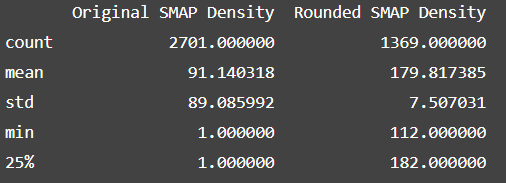

In [ ]:
# Function to round coordinates based on a tolerance
def process_smap_with_tolerance(data, tolerance=1e-5):
    """
    Rounds latitude and longitude coordinates in the dataset to the specified tolerance.

    Args:
        data (pd.DataFrame): The SMAP dataset with 'latitude' and 'longitude' columns.
        tolerance (float): The precision to round the coordinates (default: 1e-5).

    Returns:
        pd.DataFrame: Processed dataset with rounded latitude and longitude.
    """
    # Number of decimal places based on the tolerance
    decimal_places = int(-np.log10(tolerance))

    # Rounding latitude and longitude to the specified precision
    data['latitude'] = data['latitude'].round(decimal_places)
    data['longitude'] = data['longitude'].round(decimal_places)

    return data

tolerance = 1e-5
processed_smap_data = process_smap_with_tolerance(clean_smap_data, tolerance)
processed_smap_data.sort_values(by=['date', 'latitude', 'longitude'], inplace=True)

# Processed dataset
processed_smap_data.to_csv("processed_clean_smap_data_with_tolerance.csv", index=False)

#Spatial kriging and temporal alignment of the ESA CCI and SMAP datasets

##  Creating a uniform spatial grid

In [ ]:
smap_data = pd.read_csv('/content/processed_clean_smap_data_with_tolerance.csv')

I created this grid to project both the ESA CCI and SMAP dataset onto it to make sure that the datasets are spatially aligned. Also, the grid spans not across the original minimum and maximum coordinate values in the processed dataset (which would have been 1369), but only across a modified min max pair to account for the edge cases.

In [ ]:
# Uniform Grid
resolution = 0.08085
lat_min, lat_max = smap_data['latitude'].min()+2*resolution, smap_data['latitude'].max()-2*resolution
lon_min, lon_max = smap_data['longitude'].min()+2*resolution, smap_data['longitude'].max()-2*resolution
uniform_latitudes = np.arange(lat_min, lat_max + resolution, resolution)
uniform_longitudes = np.arange(lon_min, lon_max + resolution, resolution)
uniform_grid = np.array(np.meshgrid(uniform_latitudes, uniform_longitudes)).T.reshape(-1, 2)
uniform_grid_df = pd.DataFrame(uniform_grid, columns=['latitude', 'longitude'])

In [ ]:
# number of grid points
len(uniform_grid)

1089

## Projecting ESA CCI Data on the fine uniform grid using kriging

In [ ]:
clean_esa_cci_data = pd.read_csv('/content/clean_esa_cci_soil_moisture.csv')

In [ ]:
from scipy.spatial.distance import pdist, squareform
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

In [ ]:
# Experimental variogram function
def experimental_variogram(data, num_lags=20):
    coords = data[['latitude', 'longitude']].values
    values = data['soil_moisture'].values
    distances = pdist(coords)
    value_diffs = pdist(values[:, None]) ** 2
    max_distance = distances.max()
    bins = np.linspace(0, max_distance, num_lags + 1)
    bin_indices = np.digitize(distances, bins)
    lags = 0.5 * (bins[:-1] + bins[1:])
    semivariance = [
        value_diffs[bin_indices == i].mean() / 2.0 if (bin_indices == i).sum() > 0 else np.nan
        for i in range(1, len(bins))
    ]
    return lags, np.array(semivariance)

# Theoretical variogram models
def spherical_model(h, nugget, sill, range_):
    return np.where(
        h <= range_,
        nugget + (sill - nugget) * (1.5 * (h / range_) - 0.5 * (h / range_)**3),
        sill
    )

def exponential_model(h, nugget, sill, range_):
    return nugget + (sill - nugget) * (1 - np.exp(-h / range_))

def gaussian_model(h, nugget, sill, range_):
    return nugget + (sill - nugget) * (1 - np.exp(-(h / range_)**2))

def power_model(h, nugget, sill, exponent):
    return nugget + sill * (h**exponent)

# Fitting variogram models and selecting the best fit
def fit_best_variogram(lags, semivariance):
    models = {
        'spherical': spherical_model,
        'exponential': exponential_model,
        'gaussian': gaussian_model,
        'power': power_model
    }
    best_model = None
    best_params = None
    best_error = float('inf')

    for name, model in models.items():
        valid = ~np.isnan(semivariance)
        try:
            if name == 'power':
                params, _ = curve_fit(
                    model, lags[valid], semivariance[valid],
                    bounds=([0, 0, 0], [np.inf, np.inf, 2])  # Exponent bound: [0, 2]
                )
            else:
                params, _ = curve_fit(
                    model, lags[valid], semivariance[valid],
                    bounds=([0, 0, 0], [np.inf, np.inf, lags.max()])
                )
            fitted_values = model(lags, *params)
            error = np.sum((fitted_values[valid] - semivariance[valid])**2)
            if error < best_error:
                best_model = name
                best_params = params
                best_error = error
        except:
            continue

    return best_model, best_params

I have used dynamic selection of variogram models to account for changes in the spatial variability with time.

In [ ]:
# Processing each date independently to evaluate the best variogram
variogram_results = []
for date in clean_esa_cci_data['date'].unique():
    date_data = clean_esa_cci_data[clean_esa_cci_data['date'] == date]
    if not date_data.empty:
        lags, semivariance = experimental_variogram(date_data)
        best_model, best_params = fit_best_variogram(lags, semivariance)
        variogram_results.append({
            'date': date,
            'model': best_model,
            'nugget': best_params[0],
            'sill': best_params[1],
            'range': best_params[2]
        })

# Results
variogram_results_df = pd.DataFrame(variogram_results)
variogram_results_df

,date,model,nugget,sill,range
0,2021-01-01,power,1.028093e-17,0.000620,0.782832
1,2021-01-02,power,2.114581e-04,0.000343,1.030237
2,2021-01-03,power,2.199909e-04,0.000264,0.127731
3,2021-01-04,power,2.588858e-08,0.000438,0.164836
4,2021-01-05,power,4.667977e-04,0.000353,1.355303
...,...,...,...,...,...
725,2022-12-27,exponential,2.471213e-10,0.000428,0.289627
726,2022-12-28,power,2.010137e-04,0.000256,0.274523
727,2022-12-29,power,1.262676e-04,0.000152,0.156248
728,2022-12-30,power,1.608651e-04,0.000200,0.474720


In [ ]:
variogram_results_df['date'] = pd.to_datetime(variogram_results_df['date'])
clean_esa_cci_data['date'] = pd.to_datetime(clean_esa_cci_data['date'])

# Interpolating ESA CCI onto Uniform Grid
esa_cci_interpolated = []
for date in clean_esa_cci_data['date'].unique():
    date_data = clean_esa_cci_data[clean_esa_cci_data['date'] == date]

    # Best model and parameters for the current date
    best_variogram = variogram_results_df[variogram_results_df['date'] == date]
    if not best_variogram.empty:
        model = best_variogram.iloc[0]['model']
    else:
        model = 'exponential'  # Fallback model if no specific model is found

    # Ordinary Kriging with the selected variogram model
    OK = OrdinaryKriging(
        date_data['longitude'].values,
        date_data['latitude'].values,
        date_data['soil_moisture'].values,
        variogram_model=model,
        verbose=False,
        enable_plotting=False
    )
    z, _ = OK.execute("grid", uniform_longitudes, uniform_latitudes)
    grid_lat, grid_lon = np.meshgrid(uniform_latitudes, uniform_longitudes)

    # Interpolated results
    interpolated_results = pd.DataFrame({
        'date': date,
        'latitude': grid_lat.flatten(),
        'longitude': grid_lon.flatten(),
        'soil_moisture': z.flatten()
    })
    esa_cci_interpolated.append(interpolated_results)

# Combining all interpolated results
esa_cci_interpolated_df = pd.concat(esa_cci_interpolated, ignore_index=True)
esa_cci_interpolated_df.sort_values(by=['date', 'latitude', 'longitude'], inplace=True)

# Replacing any value < 0 or >1 with NaN
esa_cci_interpolated_df['soil_moisture'] = esa_cci_interpolated_df['soil_moisture'].apply(lambda x: np.nan if x < 0 or x > 1 else x)

# CSV
esa_cci_interpolated_df.to_csv('esa_cci_interpolated.csv', index=False)

In [ ]:
esa_cci_interpolated = pd.read_csv('/content/esa_cci_interpolated.csv')

In [ ]:
esa_cci_interpolated['soil_moisture'].describe()

,soil_moisture
count,794934.000000
mean,0.225881
std,0.074549
min,0.002275
25%,0.157493
50%,0.231043
75%,0.293033
max,0.420107


In [ ]:
# Number of grid points per date
esa_cci_interpolated['date'].value_counts()

,count
date,
2021-01-01,1089
2022-04-25,1089
2022-04-27,1089
2022-04-28,1089
2022-04-29,1089
...,...
2021-09-03,1089
2021-09-04,1089
2021-09-05,1089


In [ ]:
# Number of nan values
esa_cci_interpolated['soil_moisture'].isna().sum()

0

## Projecting SMAP data on the fine uniform gird

In [ ]:
processed_clean_smap_data = pd.read_csv('/content/processed_clean_smap_data_with_tolerance.csv')

IDW has been applied in this case because the dataset is already on the desired resolution and just required a little bit of alignment.  

In [ ]:
# Inverse Distance Weighting (IDW) for interpolation
def idw_interpolation(points, values, grid_points, power=2):
    grid_values = []
    for gp in grid_points:
        distances = np.sqrt(((points - gp) ** 2).sum(axis=1))
        weights = 1 / (distances ** power + 1e-12)  # To avoid division by zero
        grid_values.append(np.sum(weights * values) / np.sum(weights))
    return np.array(grid_values)

result_data = []

for date in processed_clean_smap_data['date'].unique():
    date_data = processed_clean_smap_data[processed_clean_smap_data['date'] == date]
    points = date_data[['latitude', 'longitude']].values
    values = date_data['soil_moisture'].values
    grid_values = idw_interpolation(points, values, uniform_grid)

    # DataFrame for this date's results
    date_results = pd.DataFrame({
        'date': date,
        'latitude': uniform_grid[:, 0],
        'longitude': uniform_grid[:, 1],
        'soil_moisture': grid_values
    })
    result_data.append(date_results)

# Combining results for all dates into a single DataFrame and sorting
final_results = pd.concat(result_data, ignore_index=True)
final_results.sort_values(by=['date', 'latitude', 'longitude'], inplace=True)

# Replacing any soil moisture values < 0 or >1 by NaN
final_results['soil_moisture'] = final_results['soil_moisture'].apply(lambda x: np.nan if x < 0 or x > 1 else x)

# Results
final_results.to_csv("smap_standardized.csv", index=False)

In [ ]:
smap_standardized = pd.read_csv('/content/smap_standardized.csv')

In [ ]:
smap_standardized['soil_moisture'].describe()

,soil_moisture
count,198198.000000
mean,0.291467
std,0.102265
min,0.069471
25%,0.217768
50%,0.273616
75%,0.349449
max,0.639964


In [ ]:
smap_standardized['date'].value_counts()

,count
date,
2021-01-04,1089
2022-03-07,1089
2022-03-15,1089
2022-03-28,1089
2022-03-31,1089
...,...
2021-08-08,1089
2021-08-11,1089
2021-08-16,1089


In [ ]:
smap_standardized['soil_moisture'].isna().sum()

0

## Temporal interpolation of standardized SMAP data

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product
import warnings
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [ ]:
warnings.filterwarnings("ignore")  # Suppress warnings for clean output

In [ ]:
smap_standardized['date'] = pd.to_datetime(smap_standardized['date'], format='%Y-%m-%d')

In [ ]:
# Date range
start_date = pd.to_datetime('2021-01-04')
end_date = pd.to_datetime('2022-12-28')
full_timeline = pd.date_range(start=start_date, end=end_date, freq='D')

In [ ]:
# Function to test stationarity
def check_stationarity(time_series):
    result = adfuller(time_series.dropna())
    return {
        "ADF Statistic": result[0],
        "p-value": result[1],
        "Critical Values": result[4],
        "Stationary": result[1] < 0.05
    }

Stationarity Test Result for Sample Grid Point: {'ADF Statistic': -3.585851663396098, 'p-value': 0.006037346119089067, 'Critical Values': {'1%': -3.4672111510631, '5%': -2.877734766803841, '10%': -2.575403364197531}, 'Stationary': True}


<Figure size 1200x600 with 0 Axes>

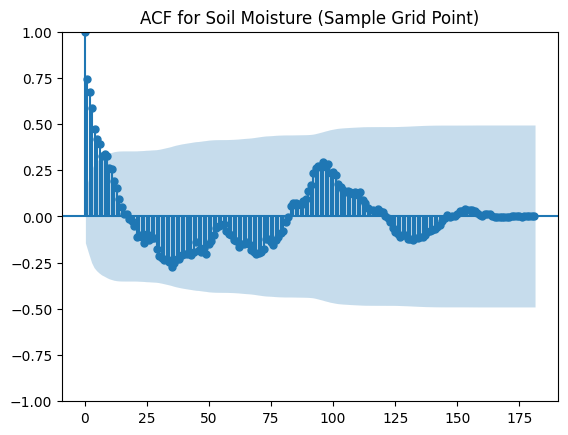

<Figure size 1200x600 with 0 Axes>

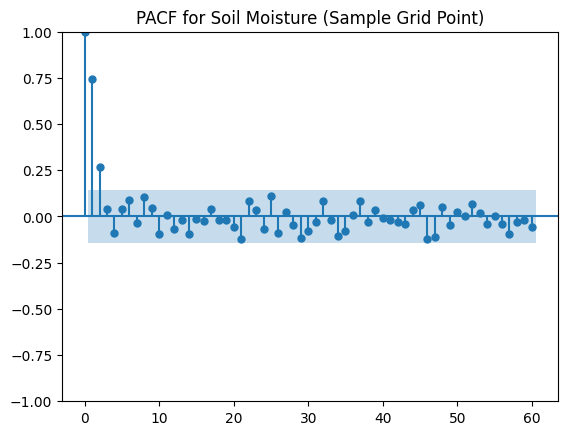

In [ ]:
# Analyzing a sample grid point for stationarity and seasonality
example_lat, example_lon = smap_standardized[['latitude', 'longitude']].iloc[0]
example_data = smap_standardized[
    (smap_standardized['latitude'] == example_lat) & (smap_standardized['longitude'] == example_lon)
]
example_data = example_data.set_index('date')['soil_moisture'].sort_index()

# Stationarity Test
stationarity_result = check_stationarity(example_data)
print("Stationarity Test Result for Sample Grid Point:", stationarity_result)

# ACF and PACF for the sample grid point
plt.figure(figsize=(12, 6))
plot_acf(example_data, lags=len(example_data) - 1, title="ACF for Soil Moisture (Sample Grid Point)")
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(example_data, lags=60, title="PACF for Soil Moisture (Sample Grid Point)")
plt.show()

Seasonal decomposition was applied to temporally interpolate missing values in the SMAP standardized dataset. The time series for each grid point was decomposed into trend, seasonality, and residual components. Missing values were temporarily filled using linear interpolation to enable decomposition. The decomposed components were interpolated separately and combined to reconstruct the complete time series, ensuring consistency across all dates.

Stationarity was tested using the Augmented Dickey-Fuller test, and seasonality was analyzed via autocorrelation. I initially tried SARIMA with parameter optimization for each grid point, but had to drop it because of the computational constraints arising from the large number of grid points (1089) and dates.

In [ ]:
results = []

# Iterating over all grid points
for lat, lon in smap_standardized[['latitude', 'longitude']].drop_duplicates().values:
    # Time series for the grid point
    grid_data = smap_standardized[
        (smap_standardized['latitude'] == lat) & (smap_standardized['longitude'] == lon)
    ]
    grid_data = grid_data.set_index('date')['soil_moisture'].sort_index()

    # Reindexing to include all dates in the full range
    grid_data = grid_data.reindex(full_timeline)  # Missing dates will have NaN

    # Filling the missing values temporarily to allow decomposition
    filled_data = grid_data.interpolate(method='linear')

    try:
        # Decomposition
        decomposition = seasonal_decompose(filled_data, model='additive', period=362, extrapolate_trend='freq')

        # Interpolating each component
        trend = decomposition.trend.interpolate(method='linear')
        seasonal = decomposition.seasonal
        residual = decomposition.resid.interpolate(method='linear')

        # Reconstruction
        interpolated_values = trend + seasonal + residual

        # Results
        results.append(pd.DataFrame({
            'date': full_timeline,
            'latitude': lat,
            'longitude': lon,
            'soil_moisture': interpolated_values
        }))
    except Exception as e:
        print(f"Decomposition failed for grid point ({lat}, {lon}): {e}")

# Combining results for all grid points and sorting
final_results = pd.concat(results, ignore_index=True)
final_results.sort_values(by=['date', 'latitude', 'longitude'], inplace=True)

# Replacing values <0 or >1 by NaN
final_results['soil_moisture'] = final_results['soil_moisture'].apply(lambda x: np.nan if x < 0 or x > 1 else x)

# Interpolated dataset
final_results.to_csv('/content/smap_daily_interpolated.csv', index=False)

print("Decomposition-based interpolation completed. Results saved to 'smap_daily_interpolated_decomposition.csv'")

Decomposition-based interpolation completed. Results saved to 'smap_daily_interpolated_decomposition.csv'


In [ ]:
smap_daily_interpolated = pd.read_csv('/content/smap_daily_interpolated.csv')

In [ ]:
smap_daily_interpolated['soil_moisture'].describe()

,soil_moisture
count,788436.000000
mean,0.293932
std,0.098320
min,0.069471
25%,0.222718
50%,0.278700
75%,0.351368
max,0.639964


In [ ]:
smap_daily_interpolated['date'].value_counts()

,count
date,
2021-01-04,1089
2022-04-25,1089
2022-04-27,1089
2022-04-28,1089
2022-04-29,1089
...,...
2021-09-03,1089
2021-09-04,1089
2021-09-05,1089


In [ ]:
# number of nan
smap_daily_interpolated['soil_moisture'].isna().sum()

0

## RMSE between ESA CCI interpolated and SMAP interpolated

In [ ]:
esa_cci_interpolated['date'] = pd.to_datetime(esa_cci_interpolated['date'])
esa_cci_interpolated_subset = esa_cci_interpolated[
    (esa_cci_interpolated['date'] >= pd.to_datetime('2021-01-04')) &
    (esa_cci_interpolated['date'] <= pd.to_datetime('2022-12-28'))
]

In [ ]:
# Rmse between esa_cci_interpolated and smap_daily_interpolated
rmse = np.sqrt(mean_squared_error(esa_cci_interpolated_subset['soil_moisture'], smap_daily_interpolated['soil_moisture']))
rmse

0.09806631715320886

This is very close to the difference in the means of the original ESA CCI and SMAP datasets.

# Assimilation using Kalman Filter

In [ ]:
# Filtering ESA CCI and SMAP datasets based on the common date range
esa_cci_interpolated_subset = esa_cci_interpolated[
    (pd.to_datetime(esa_cci_interpolated['date']) >= pd.to_datetime('2021-01-04')) &
    (pd.to_datetime(esa_cci_interpolated['date']) <= pd.to_datetime('2022-12-28'))
]

smap_interpolated_subset = smap_daily_interpolated[
    (pd.to_datetime(smap_daily_interpolated['date']) >= pd.to_datetime('2021-01-04')) &
    (pd.to_datetime(smap_daily_interpolated['date']) <= pd.to_datetime('2022-12-28'))
]

# Pivoting datasets to align by spatial grid and time
esa_soil_moisture = esa_cci_interpolated_subset.pivot_table(
    index='date', columns=['latitude', 'longitude'], values='soil_moisture'
)
smap_soil_moisture = smap_interpolated_subset.pivot_table(
    index='date', columns=['latitude', 'longitude'], values='soil_moisture'
)

esa_soil_moisture = esa_soil_moisture.sort_index(axis=1).sort_index(axis=0)
smap_soil_moisture = smap_soil_moisture.sort_index(axis=1).sort_index(axis=0)

# Kalman filter function
def kalman_filter(esa_data, smap_data, process_noise=0.01, obs_error=0.05):
    """
    Assimilating soil moisture data using the Kalman Filter
    """
    state = esa_data.iloc[0].values
    P = np.eye(len(state)) * 0.1
    Q = process_noise
    R = obs_error
    H = np.eye(len(state))
    assimilated_states = []

    for t in range(esa_data.shape[0]):
        obs = smap_data.iloc[t].values
        obs = np.where(np.isnan(obs), np.nanmean(obs), obs)
        state_prior = state
        P_prior = P + Q * np.eye(len(state))
        K = P_prior @ H.T @ np.linalg.inv(H @ P_prior @ H.T + R * np.eye(len(state)))
        state = state_prior + K @ (obs - H @ state_prior)
        P = (np.eye(len(state)) - K @ H) @ P_prior
        assimilated_states.append(state)

    return pd.DataFrame(
        np.array(assimilated_states),
        index=esa_data.index,
        columns=esa_data.columns
    )

# Assimilation
assimilated_soil_moisture = kalman_filter(esa_soil_moisture, smap_soil_moisture)
output_file_path = 'kalman_assimilated_soil_moisture.csv'
assimilated_soil_moisture.to_csv(output_file_path, index=False)